In [1]:
import pandas as pd 
import seaborn as sns
import regex as re 
import numpy as np
from tqdm import tqdm
import concurrent.futures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from geopy.distance import geodesic
import difflib

C:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import gradio as gr

In [3]:
df = pd.read_csv(r'fianl_data.csv')

In [4]:
df

,sqft,location,pincode,price,agent,bedrooms,bathroom,parking,furniture,transaction_type,name,gym,links
0,3100sqft,"Park View, Bandra West, Mumbai South West, Mah...","Mumbai\nWestern Mumbai, \nBandra West Pin Code...",₹19.0 cr,certified agent,5beds,6baths,4 covered parking,NaN,New Property,5-BHK-3100-Sq-ft-Penthouse-FOR-Sale-Bandra-Wes...,NaN,https://www.magicbricks.com/propertyDetails/5-...
1,2200sqft,"Piramal Revanta, Behind Nirmal Lifestyle mall,...","Mumbai\nCentral Mumbai, \nMulund West Pin Code...",₹5.90 cr,Not certified,5beds,5baths,3 covered parking,unfurnished,New Property,5-BHK-3410-Sq-ft-Penthouse-FOR-Sale-Mulund-Wes...,yes,https://www.magicbricks.com/propertyDetails/5-...
2,3600sqft,"2602 challenger tower, Thakur Village, Mumbai ...","Mumbai\nWestern Mumbai, Pin Code: 400101",₹12.0 cr,Not certified,4beds,4baths,1 covered parking,NaN,Resale,4-BHK-4200-Sq-ft-Penthouse-FOR-Sale-Thakur-Vil...,NaN,https://www.magicbricks.com/propertyDetails/4-...
3,4114sqft,"Goregaon East, Mumbai, Goregaon East, Mumbai -...","Mumbai\nWestern Mumbai, \nGoregaon East Pin Co...",₹22.0 cr,Not certified,5beds,6baths,5 covered parking,NaN,Resale,5-BHK-6223-Sq-ft-Penthouse-FOR-Sale-Goregaon-E...,yes,https://www.magicbricks.com/propertyDetails/5-...
4,1602sqft,"Kandivali East, Mumbai, Akurli Nagar, Mumbai -...","Mumbai\nWestern Mumbai, Pin Code: 400101",₹4.95 cr,certified agent,4beds,4baths,3 covered parking,NaN,New Property,4-BHK-2800-Sq-ft-Penthouse-FOR-Sale-Akurli-Nag...,NaN,https://www.magicbricks.com/propertyDetails/4-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,2700sqft,"101., Juhu, Mumbai - Western Mumbai, Maharashtra","Mumbai\nWestern Mumbai, \nJuhu Pin Code: 400049",₹15.0 cr,Not certified,4beds,3baths,2 covered parking,furnished,Resale,4-BHK-3100-Sq-ft-Multistorey-Apartment-FOR-Sal...,NaN,https://www.magicbricks.com/propertyDetails/4-...
14208,5615sqft,"Mumbai, Nariman Point, Mumbai - South Mumbai, ...","Mumbai\nSouth Mumbai, \nNariman Point Pin Code...",₹45.0 cr,Not certified,4beds,5baths,No covered parking,unfurnished,New Property,4-BHK-9065-Sq-ft-Multistorey-Apartment-FOR-Sal...,NaN,https://www.magicbricks.com/propertyDetails/4-...
14209,1926sqft,"L b s road, Mulund West, Mumbai - Central Mumb...","Mumbai\nCentral Mumbai, \nMulund West Pin Code...",₹6.25 cr,Not certified,4beds,4baths,3 covered parking,NaN,Resale,4-BHK-1926-Sq-ft-Multistorey-Apartment-FOR-Sal...,NaN,https://www.magicbricks.com/propertyDetails/4-...
14210,1578sqft,"Mulund West, Mulund West, Mumbai - Central Mum...","Mumbai\nCentral Mumbai, \nMulund West Pin Code...",₹2.95 cr,certified agent,4beds,3baths,1 covered parking,NaN,New Property,4-BHK-1578-Sq-ft-Multistorey-Apartment-FOR-Sal...,yes,https://www.magicbricks.com/propertyDetails/4-...


In [5]:
df.rename(columns={'sqft':'carpet_area_sqft'},inplace=True)

In [6]:
df.duplicated().sum()

592

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.isnull().sum()

carpet_area_sqft      525
location              502
pincode              1288
price                 432
agent                   0
bedrooms              856
bathroom              590
parking                 0
furniture            3425
transaction_type      460
name                    0
gym                 11914
links                   0
dtype: int64

In [9]:
df.drop(['gym','location'],inplace=True,axis=1)

In [10]:
df.dropna(inplace=True)

In [11]:
df.shape

(8984, 11)

In [12]:
def categorize_property_type(name):
    if 'Penthouse' in name:
        return 'Penthouse'
    elif 'Villa' in name:
        return 'Villa'
    elif 'Studio' in name:
        return 'Studio'
    else:
        return 'Apartment'

df['property_type'] = df['name'].apply(categorize_property_type)


In [13]:
df['bedrooms']=df['bedrooms'].apply(lambda x : re.sub('[^0-9]',' ',str(x)))
df['bathroom']=df['bathroom'].apply(lambda x : re.sub('[^0-9]',' ',str(x)))

In [14]:
df['parking']=df['parking'].map({'No covered parking':'No covered parking'})
df['parking']=df['parking'].fillna('covered parking')

In [15]:
df['parking'].value_counts()

No covered parking    7065
covered parking       1919
Name: parking, dtype: int64

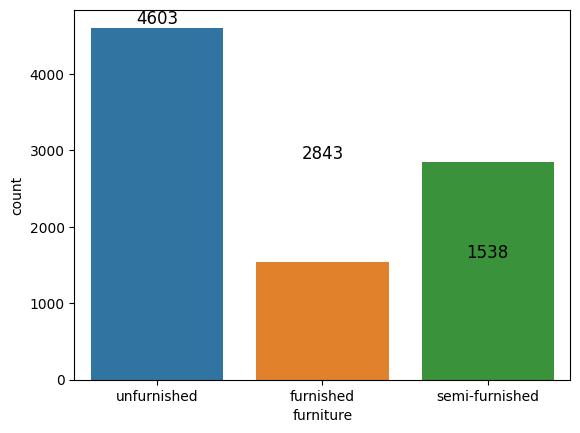

In [16]:
counts = df['furniture'].value_counts()

# Create a countplot
ax = sns.countplot(data=df, x='furniture')

# Add counts on top of the bars
for i, count in enumerate(counts):
    ax.text(i, count, str(count), ha='center', va='bottom', fontsize=12)


In [17]:
df['pincode']=df['pincode'].str.split(':').str[-1]

In [18]:
df['pincode'].value_counts()

 400047     555
 401107     452
 400067     367
 400071     360
 400080     335
           ... 
 401106       2
 400020       2
 400021       2
 400062       1
\n400009      1
Name: pincode, Length: 104, dtype: int64

In [19]:
df['carpet_area_sqft']=df['carpet_area_sqft'].apply(lambda x : re.sub('[^0-9]',' ',str(x)))

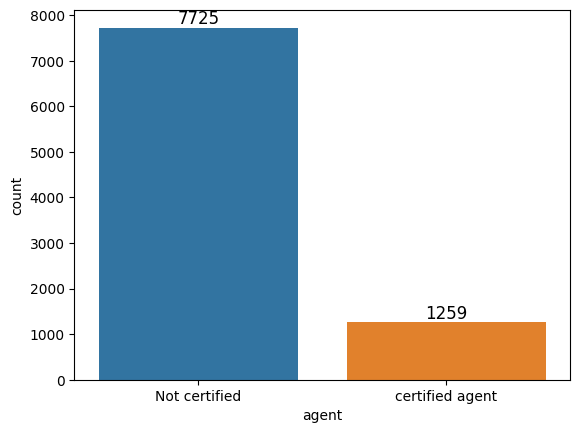

In [20]:
counts = df['agent'].value_counts()

# Create a countplot
ax = sns.countplot(data=df, x='agent')

# Add counts on top of the bars
for i, count in enumerate(counts):
    ax.text(i, count, str(count), ha='center', va='bottom', fontsize=12)


In [21]:
 df['transaction_type'].value_counts()

Resale          6654
New Property    2307
Other             12
Rent              11
Name: transaction_type, dtype: int64

In [22]:
df['price'].unique()

array(['₹5.90 cr', '₹23.95 cr', '₹18.50 cr', ..., '₹50.0 cr', '₹36.0 cr',
       '₹7.11 cr'], dtype=object)

In [23]:
df['price']=df['price'].str.replace('₹','')

In [24]:
df['price'].str.split().str[1].unique()

array(['cr', 'for', 'lac', nan], dtype=object)

In [25]:
df['price']

1         5.90 cr
7        23.95 cr
17       18.50 cr
22        45.0 cr
24         8.0 cr
           ...   
14204     7.11 cr
14206     7.99 cr
14207     15.0 cr
14208     45.0 cr
14211     5.35 cr
Name: price, Length: 8984, dtype: object

In [26]:
df.drop(df[df['price']=='call for price'].index,inplace=True)

In [27]:
lst=[]
for i in df['price']:
    if 'cr' in i:
        a=i.split()[0]
        a=(eval(a)) * 10000000
        lst.append(round(a))
    elif 'lac' in i:
        a=i.split()[0]
        a=(eval(a)) * 100000
        lst.append(round(a))


In [28]:
df.drop(df[df['price']=='90,000'].index,inplace=True)

In [29]:
df['prc']=lst

In [30]:
df.head()

,carpet_area_sqft,pincode,price,agent,bedrooms,bathroom,parking,furniture,transaction_type,name,links,property_type,prc
1,2200,400080,5.90 cr,Not certified,5,5,covered parking,unfurnished,New Property,5-BHK-3410-Sq-ft-Penthouse-FOR-Sale-Mulund-Wes...,https://www.magicbricks.com/propertyDetails/5-...,Penthouse,59000000
7,3926,400010,23.95 cr,certified agent,4,4,covered parking,unfurnished,New Property,4-BHK-3926-Sq-ft-Penthouse-FOR-Sale-Byculla-in...,https://www.magicbricks.com/propertyDetails/4-...,Penthouse,239500000
17,4200,400049,18.50 cr,Not certified,4,4,No covered parking,furnished,Resale,4-BHK-5500-Sq-ft-Penthouse-FOR-Sale-Juhu-in-Mu...,https://www.magicbricks.com/propertyDetails/4-...,Penthouse,185000000
22,4800,400049,45.0 cr,Not certified,5,5,No covered parking,furnished,Resale,5-BHK-5800-Sq-ft-Penthouse-FOR-Sale-Juhu-in-Mu...,https://www.magicbricks.com/propertyDetails/5-...,Penthouse,450000000
24,2250,400071,8.0 cr,Not certified,4,5,No covered parking,furnished,Resale,4-BHK-2600-Sq-ft-Penthouse-FOR-Sale-Chembur-in...,https://www.magicbricks.com/propertyDetails/4-...,Penthouse,80000000


In [31]:
data = df[['links','pincode','bedrooms','bathroom','parking','furniture','carpet_area_sqft','agent','transaction_type','property_type','prc']]

In [32]:
data.reset_index(inplace=True)

In [33]:
data.drop('index',axis=1,inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_10564\743382519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('index',axis=1,inplace=True)


In [34]:
data

,links,pincode,bedrooms,bathroom,parking,furniture,carpet_area_sqft,agent,transaction_type,property_type,prc
0,https://www.magicbricks.com/propertyDetails/5-...,400080,5,5,covered parking,unfurnished,2200,Not certified,New Property,Penthouse,59000000
1,https://www.magicbricks.com/propertyDetails/4-...,400010,4,4,covered parking,unfurnished,3926,certified agent,New Property,Penthouse,239500000
2,https://www.magicbricks.com/propertyDetails/4-...,400049,4,4,No covered parking,furnished,4200,Not certified,Resale,Penthouse,185000000
3,https://www.magicbricks.com/propertyDetails/5-...,400049,5,5,No covered parking,furnished,4800,Not certified,Resale,Penthouse,450000000
4,https://www.magicbricks.com/propertyDetails/4-...,400071,4,5,No covered parking,furnished,2250,Not certified,Resale,Penthouse,80000000
...,...,...,...,...,...,...,...,...,...,...,...
8893,https://www.magicbricks.com/propertyDetails/4-...,400019,4,4,No covered parking,unfurnished,1727,certified agent,New Property,Apartment,71100000
8894,https://www.magicbricks.com/propertyDetails/4-...,400014,4,5,covered parking,semi-furnished,2102,Not certified,New Property,Apartment,79900000
8895,https://www.magicbricks.com/propertyDetails/4-...,400049,4,3,covered parking,furnished,2700,Not certified,Resale,Apartment,150000000
8896,https://www.magicbricks.com/propertyDetails/4-...,400021,4,5,No covered parking,unfurnished,5615,Not certified,New Property,Apartment,450000000


In [35]:
pin_map = pd.read_csv(r'pin_mapping.csv')

In [36]:
pin_map=pin_map[['Location','Pincode']]

In [37]:
pin_map.rename(columns={'Location':'location','Pincode':'pincode'},inplace=True)

In [38]:
data['pincode']=data['pincode'].astype(int)

C:\Users\hp\AppData\Local\Temp\ipykernel_10564\3091200559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pincode']=data['pincode'].astype(int)


In [39]:
data = data.merge(pin_map,on='pincode',how='left')

In [40]:
data

,links,pincode,bedrooms,bathroom,parking,furniture,carpet_area_sqft,agent,transaction_type,property_type,prc,location
0,https://www.magicbricks.com/propertyDetails/5-...,400080,5,5,covered parking,unfurnished,2200,Not certified,New Property,Penthouse,59000000,Mulund Dd Road
1,https://www.magicbricks.com/propertyDetails/4-...,400010,4,4,covered parking,unfurnished,3926,certified agent,New Property,Penthouse,239500000,Dockyard Road
2,https://www.magicbricks.com/propertyDetails/4-...,400010,4,4,covered parking,unfurnished,3926,certified agent,New Property,Penthouse,239500000,Mazgaon
3,https://www.magicbricks.com/propertyDetails/4-...,400010,4,4,covered parking,unfurnished,3926,certified agent,New Property,Penthouse,239500000,Mazgaon Dock
4,https://www.magicbricks.com/propertyDetails/4-...,400010,4,4,covered parking,unfurnished,3926,certified agent,New Property,Penthouse,239500000,Mazgaon Road
...,...,...,...,...,...,...,...,...,...,...,...,...
16071,https://www.magicbricks.com/propertyDetails/4-...,400014,4,5,covered parking,semi-furnished,2102,Not certified,New Property,Apartment,79900000,Naigaon
16072,https://www.magicbricks.com/propertyDetails/4-...,400049,4,3,covered parking,furnished,2700,Not certified,Resale,Apartment,150000000,Juhu
16073,https://www.magicbricks.com/propertyDetails/4-...,400021,4,5,No covered parking,unfurnished,5615,Not certified,New Property,Apartment,450000000,Nariman Point
16074,https://www.magicbricks.com/propertyDetails/4-...,400021,4,5,No covered parking,unfurnished,5615,Not certified,New Property,Apartment,450000000,New Yogakshema


In [41]:
data['pincode']=data['pincode'].astype(str)

In [42]:
data['bedrooms']=data['bedrooms'].str.strip()
data['bathroom']=data['bathroom'].str.strip()
data['carpet_area_sqft']=data['carpet_area_sqft'].str.strip()

In [43]:
data['bathroom'].unique()

array(['5', '4', '6', '3', '2', '1', '', '7', '8'], dtype=object)

In [44]:
data[data['bathroom']=='']

,links,pincode,bedrooms,bathroom,parking,furniture,carpet_area_sqft,agent,transaction_type,property_type,prc,location
78,https://www.magicbricks.com/propertyDetails/1-...,400074,1,,No covered parking,unfurnished,500,Not certified,Resale,Apartment,4600000,Chembur Extension
1022,https://www.magicbricks.com/propertyDetails/1-...,400037,1,,No covered parking,unfurnished,150,Not certified,Resale,Apartment,2800000,Antop Hill
1096,https://www.magicbricks.com/propertyDetails/1-...,400097,1,,No covered parking,unfurnished,100,Not certified,Resale,Apartment,3000000,Malad East
1097,https://www.magicbricks.com/propertyDetails/1-...,400097,1,,No covered parking,unfurnished,100,Not certified,Resale,Apartment,3000000,"Rani Sati marg , malad"
1284,https://www.magicbricks.com/propertyDetails/1-...,400071,1,,No covered parking,unfurnished,200,Not certified,Resale,Apartment,4500000,Chembur
1543,https://www.magicbricks.com/propertyDetails/1-...,400055,1,,No covered parking,unfurnished,200,Not certified,Resale,Apartment,2000000,Santacruz(east)
1544,https://www.magicbricks.com/propertyDetails/1-...,400055,1,,No covered parking,unfurnished,200,Not certified,Resale,Apartment,2000000,Vakola
4866,https://www.magicbricks.com/propertyDetails/3-...,400104,3,,No covered parking,unfurnished,900,Not certified,New Property,Apartment,30000000,Motilal Nagar
4937,https://www.magicbricks.com/propertyDetails/1-...,400047,1,,No covered parking,unfurnished,350,Not certified,New Property,Apartment,14000000,mumbai
8866,https://www.magicbricks.com/propertyDetails/1-...,400019,1,,No covered parking,unfurnished,225,Not certified,Resale,Apartment,4200000,Matunga Railway workshop


In [45]:
data[(data['bathroom']=='') & (data['bedrooms']==1)]

,links,pincode,bedrooms,bathroom,parking,furniture,carpet_area_sqft,agent,transaction_type,property_type,prc,location


In [46]:
data.loc[(data['bathroom'] == '') & (data['bedrooms'] == 1), 'bathroom'] = 1

In [47]:
data[data['bathroom']=='']

,links,pincode,bedrooms,bathroom,parking,furniture,carpet_area_sqft,agent,transaction_type,property_type,prc,location
78,https://www.magicbricks.com/propertyDetails/1-...,400074,1,,No covered parking,unfurnished,500,Not certified,Resale,Apartment,4600000,Chembur Extension
1022,https://www.magicbricks.com/propertyDetails/1-...,400037,1,,No covered parking,unfurnished,150,Not certified,Resale,Apartment,2800000,Antop Hill
1096,https://www.magicbricks.com/propertyDetails/1-...,400097,1,,No covered parking,unfurnished,100,Not certified,Resale,Apartment,3000000,Malad East
1097,https://www.magicbricks.com/propertyDetails/1-...,400097,1,,No covered parking,unfurnished,100,Not certified,Resale,Apartment,3000000,"Rani Sati marg , malad"
1284,https://www.magicbricks.com/propertyDetails/1-...,400071,1,,No covered parking,unfurnished,200,Not certified,Resale,Apartment,4500000,Chembur
1543,https://www.magicbricks.com/propertyDetails/1-...,400055,1,,No covered parking,unfurnished,200,Not certified,Resale,Apartment,2000000,Santacruz(east)
1544,https://www.magicbricks.com/propertyDetails/1-...,400055,1,,No covered parking,unfurnished,200,Not certified,Resale,Apartment,2000000,Vakola
4866,https://www.magicbricks.com/propertyDetails/3-...,400104,3,,No covered parking,unfurnished,900,Not certified,New Property,Apartment,30000000,Motilal Nagar
4937,https://www.magicbricks.com/propertyDetails/1-...,400047,1,,No covered parking,unfurnished,350,Not certified,New Property,Apartment,14000000,mumbai
8866,https://www.magicbricks.com/propertyDetails/1-...,400019,1,,No covered parking,unfurnished,225,Not certified,Resale,Apartment,4200000,Matunga Railway workshop


In [48]:
data.loc[data['bathroom'] == '', 'bathroom'] = 2

In [49]:
#data['bedrooms']=data['bedrooms'].astype(int)
#data['bathroom']=data['bathroom'].astype(int)
#data['carpet_area_sqft'] = data['carpet_area_sqft'].str.replace(',', '').str.replace(' ', '').astype(int)

In [50]:
data.head()

,links,pincode,bedrooms,bathroom,parking,furniture,carpet_area_sqft,agent,transaction_type,property_type,prc,location
0,https://www.magicbricks.com/propertyDetails/5-...,400080,5,5,covered parking,unfurnished,2200,Not certified,New Property,Penthouse,59000000,Mulund Dd Road
1,https://www.magicbricks.com/propertyDetails/4-...,400010,4,4,covered parking,unfurnished,3926,certified agent,New Property,Penthouse,239500000,Dockyard Road
2,https://www.magicbricks.com/propertyDetails/4-...,400010,4,4,covered parking,unfurnished,3926,certified agent,New Property,Penthouse,239500000,Mazgaon
3,https://www.magicbricks.com/propertyDetails/4-...,400010,4,4,covered parking,unfurnished,3926,certified agent,New Property,Penthouse,239500000,Mazgaon Dock
4,https://www.magicbricks.com/propertyDetails/4-...,400010,4,4,covered parking,unfurnished,3926,certified agent,New Property,Penthouse,239500000,Mazgaon Road


In [51]:
data.rename(columns={'prc':'price'},inplace=True)

In [52]:
data.to_csv(r'clean.csv',index=False)

In [51]:
data['property_type'].unique()

array(['Penthouse', 'Apartment', 'Villa'], dtype=object)

In [52]:
data.columns

Index(['links', 'pincode', 'bedrooms', 'bathroom', 'parking', 'furniture',
       'carpet_area_sqft', 'agent', 'transaction_type', 'property_type', 'prc',
       'location'],
      dtype='object')

In [53]:
data = data.astype(str)

In [88]:
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import gradio as gr

# Assume you have the data and user_input as described in your code

data['combined_features'] = data[['pincode', 'bedrooms', 'bathroom', 'parking', 'furniture',
       'carpet_area_sqft', 'agent', 'transaction_type', 'property_type', 'prc']].apply(lambda row: ' '.join(row), axis=1)

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(data['combined_features'])

user_tfidf = tfidf_vectorizer.transform([' '.join(user_input.values())])

cosine_similarities = linear_kernel(user_tfidf, tfidf_matrix).flatten()

pincode_weight = 2.0  # You can adjust this weight according to your preference
sqft_weight = 2.0  # You can adjust this weight according to your preference

# Check if 'pincode' and 'sqft' exist in the vocabulary
if 'pincode' in tfidf_vectorizer.vocabulary_ and 'sqft' in tfidf_vectorizer.vocabulary_:
    data['similarity'] = cosine_similarities
    data['similarity'] += pincode_weight * tfidf_matrix[:, tfidf_vectorizer.vocabulary_['pincode']].toarray().flatten()
    data['similarity'] += sqft_weight * tfidf_matrix[:, tfidf_vectorizer.vocabulary_['sqft']].toarray().flatten()
else:
    data['similarity'] = cosine_similarities

sorted_data = data.sort_values(by='similarity', ascending=False)

N = 5  
pd.set_option('display.max_colwidth', 150)
recommendations = sorted_data[['pincode','location','bedrooms','transaction_type','property_type','prc','links']].head(N)
print("Recommendations for the user:")
print(recommendations)


Recommendations for the user:
      pincode         location bedrooms transaction_type property_type  \
14259  400064            Orlem        2           Resale     Apartment   
14256  400064   Liberty Garden        2           Resale     Apartment   
14258  400064  Malad West dely        2           Resale     Apartment   
14257  400064            Malad        2           Resale     Apartment   
9293   400055           Vakola        2           Resale     Apartment   

            prc  \
14259  17000000   
14256  17000000   
14258  17000000   
14257  17000000   
9293   17000000   

                                                                                                                                             links  
14259  https://www.magicbricks.com/propertyDetails/2-BHK-875-Sq-ft-Multistorey-Apartment-FOR-Sale-Liberty-Garden-in-Mumbai&id=4d423638373939313339  
14256  https://www.magicbricks.com/propertyDetails/2-BHK-875-Sq-ft-Multistorey-Apartment-FOR-Sale-Liberty-Garden

In [62]:
data['p'].value_counts()

parking
No covered parking    12397
covered parking        3679
Name: count, dtype: int64